- https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB
-  

In [13]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from ML_loader import DatasetLoader,ModelLoader


In [14]:
#Get data 
loader = DatasetLoader()
#loader.read_dataset('./features_resnet.csv',class_path='labelsDefault.txt',separator=',')
loader.read_dataset('./features_googlenet.csv',class_path='labelsDefault.txt',separator=',')
#loader.read_dataset('./partial_database.csv',class_path='labelsDefault.txt',separator=',')
#loader.add_dataset(file_path='./features_googlenet.csv')
loader.add_dataset(file_path='./partial_database.csv')
print(loader.df.head())
loader.split_dataset()

#Normalize data, if not already normalized
print(np.shape(loader.X_train),np.shape(loader.X_test),np.shape(loader.y_train),np.shape(loader.y_test))

          0         1         2         3         4         5         6  \
0  0.068987  0.047691  0.040669  0.137358  0.039775  0.142994  0.063873   
1  0.088476  0.040340  0.045385  0.169379  0.027662  0.163092  0.058977   
2  0.061500  0.030592  0.060100  0.138120  0.024295  0.115686  0.093906   
3  0.075212  0.045083  0.054669  0.128659  0.038938  0.140928  0.097807   
4  0.081000  0.042667  0.055589  0.124680  0.031209  0.122541  0.071173   

          7         8         9  ...   AU12_r   AU14_r   AU15_r   AU17_r  \
0  0.153312  0.161842  0.207493  ...     0.10     0.00     0.71     0.89   
1  0.140995  0.119027  0.137874  ...     0.39     0.05     0.46     1.47   
2  0.113927  0.166207  0.166614  ...     0.36     0.07     0.22     2.36   
3  0.127351  0.110538  0.160750  ...     0.19     0.07     0.60     2.14   
4  0.129998  0.153568  0.176524  ...     0.25     0.02     0.38     1.89   

    AU20_r   AU23_r   AU25_r   AU26_r   AU45_r  class  
0     0.00     0.00     0.00     0.8

In [15]:
#Get model
model = ModelLoader()
model.set_model(MultinomialNB())

cv = RepeatedStratifiedKFold(n_splits=22, n_repeats=3, random_state=1)

#Optimization 
param = {'alpha': np.linspace(0.5, 1.5, 6),
            'fit_prior': [True, False]}

model.set_optimal_params(param)

model.optimize(loader.X_train,loader.y_train,cv=cv,scoring='accuracy',n_iter=10)

#Train model with optimal params
model.set_model(MultinomialNB(**model.optimal_params))


Partial fit
Score accuracy group 0:  0.8695652173913043
Score accuracy group learned 0:  0.8695652173913043
Score accuracy global:  0.29051383399209485
Memory:  467.328125 MB
Partial fit
Score accuracy group 1:  0.9021739130434783
Score accuracy group learned 0:  0.860248447204969
Score accuracy group learned 1:  0.9021739130434783
Score accuracy global:  0.38636363636363635
Memory:  446.6015625 MB
Partial fit
Score accuracy group 2:  0.6141304347826086
Score accuracy group learned 0:  0.7422360248447205
Score accuracy group learned 1:  0.9021739130434783
Score accuracy group learned 2:  0.6141304347826086
Score accuracy global:  0.45948616600790515
Memory:  447.10546875 MB
Partial fit
Score accuracy group 3:  0.5507246376811594
Score accuracy group learned 0:  0.7080745341614907
Score accuracy group learned 1:  0.8913043478260869
Score accuracy group learned 2:  0.5760869565217391
Score accuracy group learned 3:  0.5507246376811594
Score accuracy global:  0.5158102766798419
Memory:  4

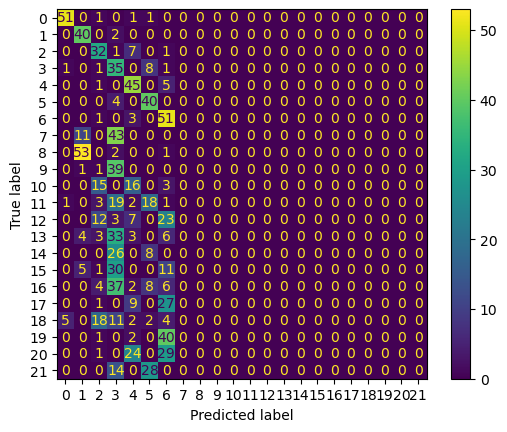

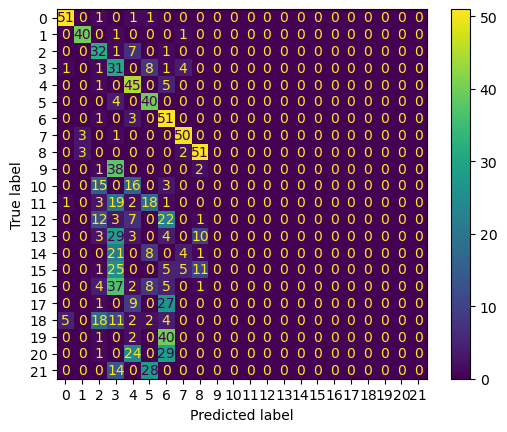

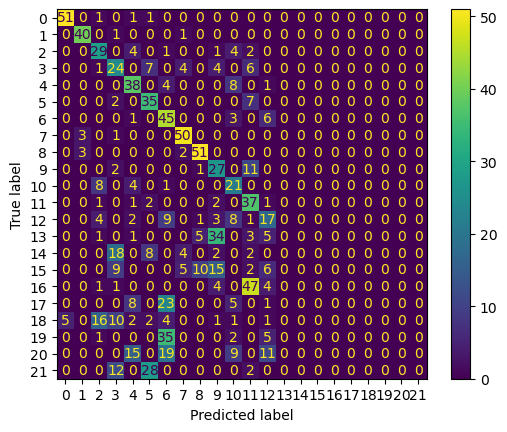

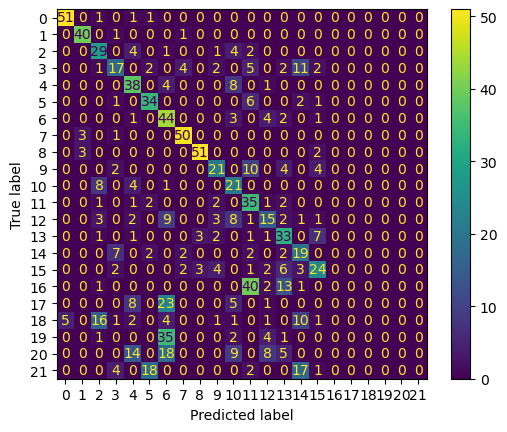

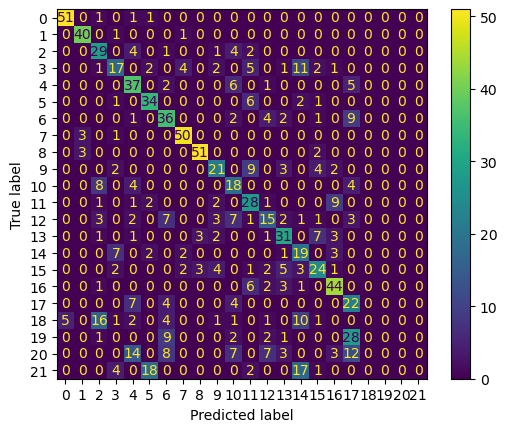

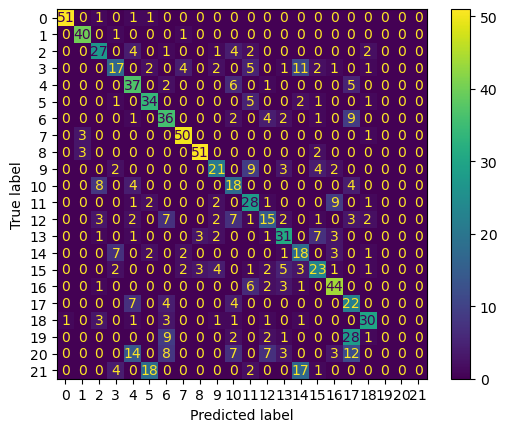

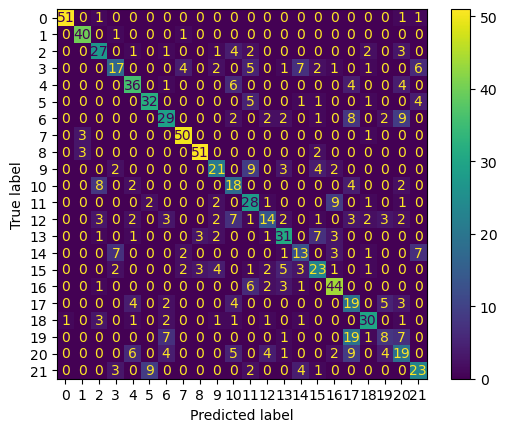

In [16]:
##Split by class, to increment by class:
class_to_group = {1:[1,2,3,4,5,6,7],2:[8,9],3:[10,11,12,13],4:[14,15,16],5:[17,18],6:[19],7:[20,21,22]}
#class_to_group = {1:[1,2,3,4,5,6,7], 2:[8], 3:[9], 4:[10], 5:[11], 6:[12], 7:[13], 8:[14], 9:[15], 10:[16], 11:[17], 12:[18], 13:[19], 14:[20], 15:[21], 16:[22]}

X_train_merged, X_test_merged, y_train_merged, y_test_merged=loader.split_dataset_class(class_to_group,random_state=1)
memory_values = []
accuracy_learned_grouped = []


#Train model
for idx,(X_train,y_train,X_test,y_test) in enumerate(zip(X_train_merged,y_train_merged,X_test_merged,y_test_merged)):
    mem,res=model.partial_fit_train(X_train,y_train,classes=loader.classes)
    print(f"Score accuracy group {idx}: ",model.score(X_test,y_test))
    accuracy_learned = []
    for i in range(idx+1):
        print(f"Score accuracy group learned {i}: ",model.score(X_test_merged[i],y_test_merged[i]))
        accuracy_learned.append(model.score(X_test_merged[i],y_test_merged[i]))
    print("Score accuracy global: ",model.score(loader.X_test,loader.y_test))
    print("Memory: ",np.mean(mem),"MB")
    memory_values.append(np.mean(mem))
    accuracy_learned_grouped.append(accuracy_learned)
    y_pred=model.predict(loader.X_test)
    cm = confusion_matrix(loader.y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()

model.reset_model()

average_memory = np.mean(memory_values)
print("Average memory usage: ", average_memory,"MB")

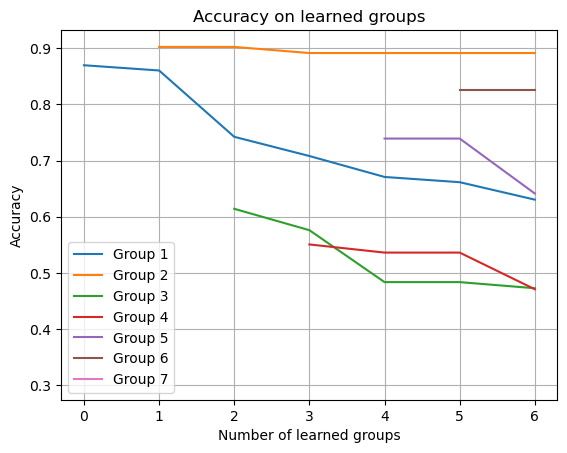

<Axes: title={'center': 'Accuracy on learned groups'}, xlabel='Number of learned groups', ylabel='Accuracy'>

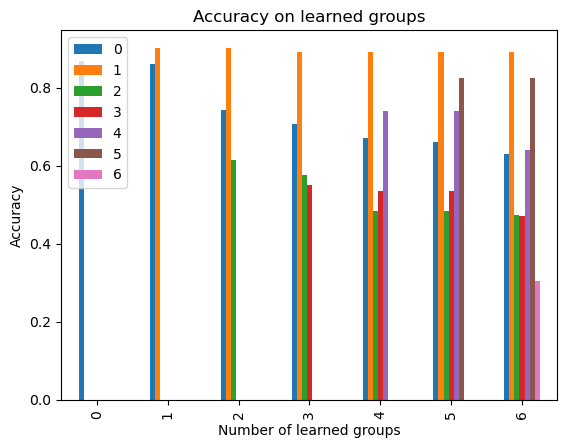

In [17]:
#Figure for accuracy on learned class
df = pd.DataFrame(accuracy_learned_grouped)
df1 = df.replace(np.nan, 0)
df=df.T

fig, ax = plt.subplots()
for i in range(len(class_to_group)):
    ax.plot(list(df.iloc[i]),label=f'Group {i+1}')

ax.set(xlabel='Number of learned groups', ylabel='Accuracy',
        title='Accuracy on learned groups')

ax.grid()
ax.legend()
plt.show()

# Bar plot 
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set(xlabel='Number of learned groups', ylabel='Accuracy',
        title='Accuracy on learned groups')

df1.plot(kind='bar', ax=ax)

Partial fit
Score accuracy batch 0:  0.575098814229249
Score accuracy global:  0.6225296442687747
Memory:  462.72982545882934 MB
Partial fit
Score accuracy batch 1:  0.5790513833992095
Score accuracy global:  0.6195652173913043
Memory:  465.4137972198642 MB
Partial fit
Score accuracy batch 2:  0.6067193675889329
Score accuracy global:  0.6205533596837944
Memory:  451.1671875 MB
Partial fit
Score accuracy batch 3:  0.5909090909090909
Score accuracy global:  0.6235177865612648
Memory:  451.69453125 MB
Partial fit
Score accuracy batch 4:  0.6086956521739131
Score accuracy global:  0.6215415019762845
Memory:  452.3446779214559 MB
Partial fit
Score accuracy batch 5:  0.6047430830039525
Score accuracy global:  0.6245059288537549
Memory:  452.971875 MB
Partial fit
Score accuracy batch 6:  0.5948616600790514
Score accuracy global:  0.6225296442687747
Memory:  454.9163607260338 MB
Partial fit
Score accuracy batch 7:  0.5968379446640316
Score accuracy global:  0.6215415019762845
Memory:  455.522

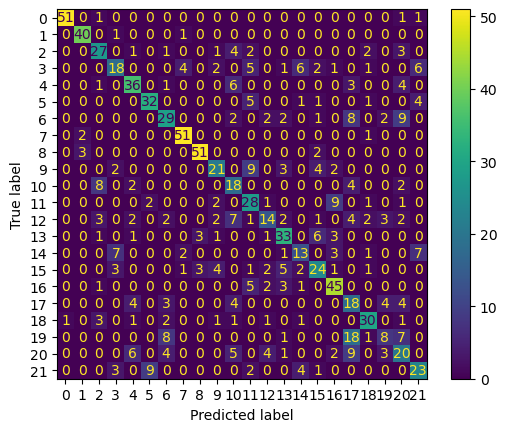

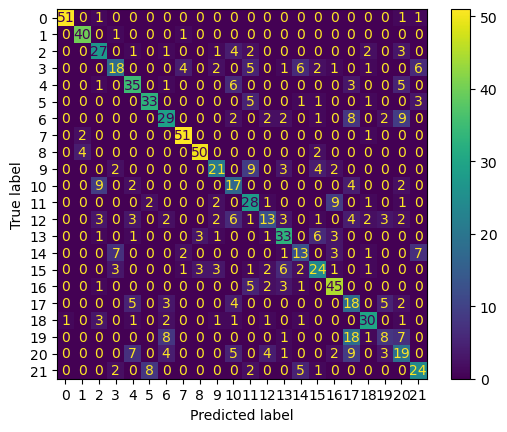

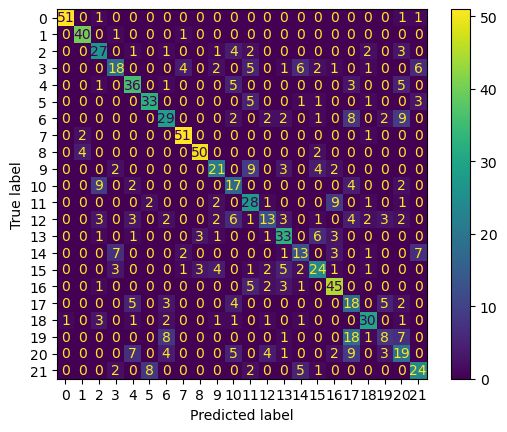

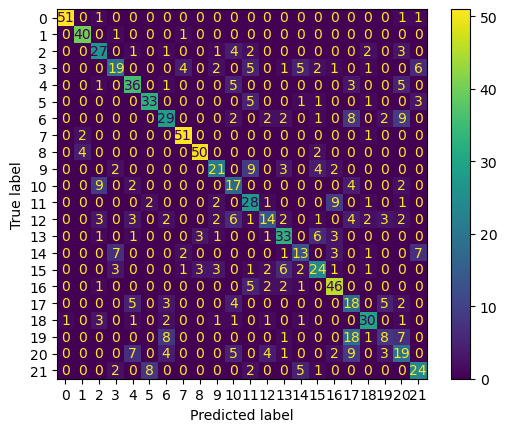

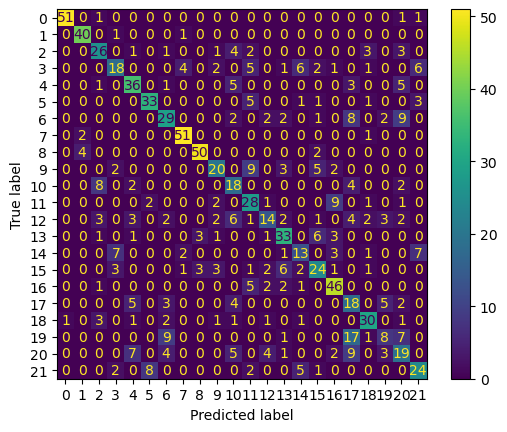

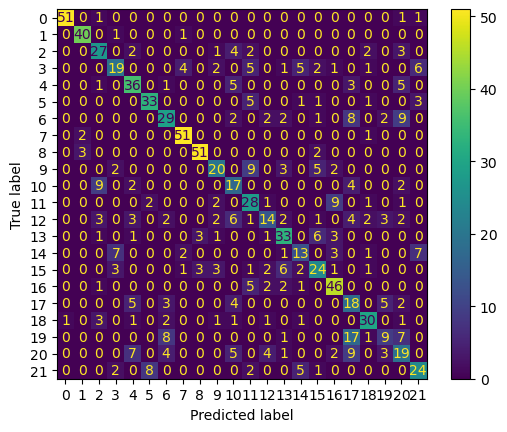

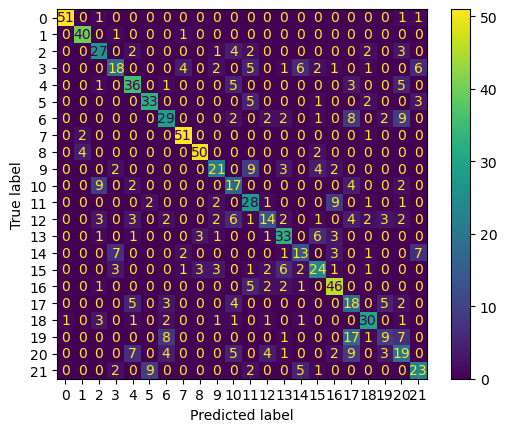

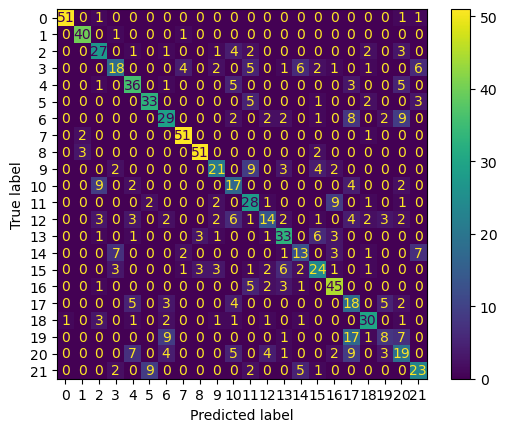

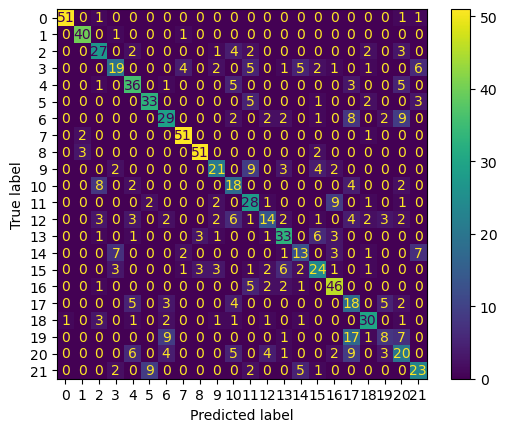

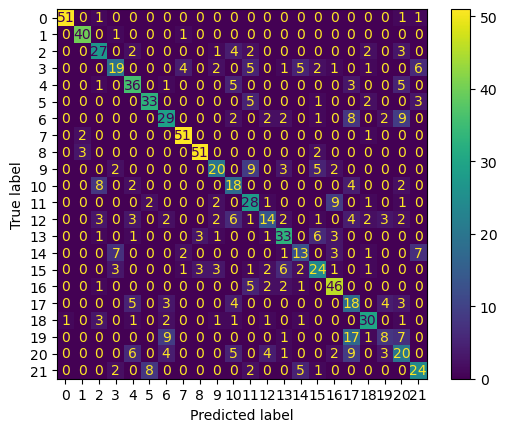

In [18]:
X_train_split_data,y_train_split_data,X_test_split_data,y_test_split_data=loader.split_dataset_data(10,random_state=1)
memory_values = []

for x in range(len(X_train_split_data)):
    mem,res=model.partial_fit_train(X_train_split_data[x],y_train_split_data[x],classes=loader.classes)
    print(f"Score accuracy batch {x}: ",model.score(X_test_split_data[x],y_test_split_data[x]))
    print("Score accuracy global: ",model.score(loader.X_test,loader.y_test))
    print("Memory: ",np.mean(mem),"MB")
    memory_values.append(np.mean(mem))

    y_pred=model.predict(loader.X_test)
    cm = confusion_matrix(loader.y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()

model.reset_model()

average_memory = np.mean(memory_values)
print("Average memory usage: ", average_memory,"MB")